# Introduzione pratica ai criteri di DiVincenzo in Qiskit 2

![](DiVincenzos.png)

*Notebook per il QiskitFallFest 2025 per il Dipartimento di Matematica e Informatica dell'Università di Catania - Fornito da IBM, tradotto e adattato da Damiano Trovato.*

## Introduzione

Il fisico David DiVincenzo ha definito cinque requisiti necessari per qualsiasi implementazione fisica di un computer quantistico, e due criteri addizionali relativi alla quantum communication. In questo notebook, osserveremo e toccheremo con mano **ogni criterio di DiVincenzo tramite dimostrazioni pratiche in Qiskit**. Invece di andare nel profondo della teoria, ogni sezione spiegherà a grandi linee un criterio, fornendone poi degli esercizi in Qiskit 2. Potrete eseguire poi i codici su simulatori o vero hardware IBM per **testare con mano questi requisiti**.

**I cinque criteri di DiVincenzo per la computazione quantistica**:

1. **Un sistema fisico scalabile con qubit ben definiti.**
2. **Possibilità di inizializzare i qubit** ad uno specifico stato (ad esempio |00…0〉).
3. **Tempi di decoerenza molto lunghi** (la coerenza dei qubit dura più del tempo di operazione delle porte).
4. **Un set universale di porte quantistiche** (capaci di effettuare operazioni unitarie arbitrarie).
5. **Possibilità di misurare specifici qubit** (leggendone lo stato).

*(DiVincenzo descrive pure due criteri relativi alla comunicazione quantistica: tl'abilità di interconvertire qubit stazionari e "volanti", e di trasmettere in maniera fedele i qubit volanti tra posti fisici. Li includiamo in una parte consigliata a fine notebook.)*

Ognuna delle seguenti sezioni coincide ad un criterio. Useremo Qiskit per illustrare il concetto tramite codice e **esperimenti interattivi** che potete provate. Ad esempio, vedremo come lo scalare il numero di qubit e la profondità del circuito influenzi i risultati del circuito (Criterio 1), come resettare lo stato dei qubit (Criterio 2), come misurare i qubit su un simulatore e su un dispositivo reale (Criterio 4), come compone Qiskit i propri gate universali (Criterio 3), come coerenza finita (T₁, T₂) impatti la computazione (Criterio 5). Arrivati alla fine, avrete un'idea più approfondita di quelle che sono le implicazioni pratiche dei criteri di DiVincenzo, e di come Qiskit ne permetta la sperimentazione.

In [1]:
# Installa i pacchetti necessari
!pip install qiskit[visualization] qiskit-ibm-runtime qiskit-aer qiskit_ibm_runtime

*Criterio 1:** *“Un sistema fisico scalabile con qubit ben definiti.”* Questo vuol dire che necessitiamo di un hardware quantistico solido per **incrementare il numero di qubit** e averne il controllo in maniera affidabile. Le proprietà di ogni qubit (livelli di energia, ratio di errori, connettività, etc.) dovrebbe essere ben nota. Essenzialmente, vogliamo poter costruire circuiti quantistici più grandi senza che il sistema si rompa. In pratica, andando ad aumentare il numero di qubit o la profondità del circuito, esso diventa prone a errori e la decoerenza si accumula, quindi, dimostrare la *scalabilità* significa anche capire come l'aumento delle dimensioni del circuito influenzi le performance.

**Obiettivo della Demo:** Usare Qiskit per dimostrare come lo scalare un circuit (nel numero di qubit o nella profondità) influenzi la fedeltà dell'output. Simuleremo uno scenario ideale, mettendono a confronto con uno rumoroso, per vedere come sistemi più grandi soccombano a decoerenza ed errori.

Per prima cosa, costruiamo un piccolo stato entangled (GHZ state) su 3 qubit, poi uno più grande su 5 qubit, per testare la scalabilità. Uno stato GHZ ad *n* qubit è $\frac{1}{\sqrt{2}}(|0...0\rangle + |1...1\rangle)$. In una simulazione ideale, misurare uno GHZ a n-qubit ha solo due possibili esiti (solo 0 o solo 1) con uguale probabilità. Compareremo l'**output ideale** ad un **output rumoroso** mentre aumentiamo il numero di qubit.

3-qubit GHZ counts (ideal): {'111': 510, '000': 514}


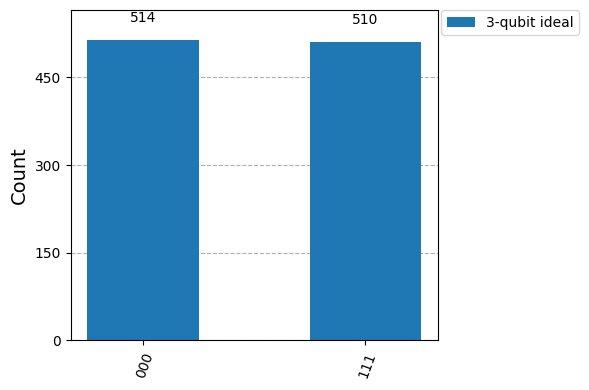

In [2]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

# GHZ a 3 qubit
qc3 = QuantumCircuit(3, 3)
qc3.h(0)
qc3.cx(0, 1)
qc3.cx(1, 2)
qc3.measure([0, 1, 2], [0, 1, 2])

# GHZ  a 5 qubit
qc5 = QuantumCircuit(5, 5)
qc5.h(0)
qc5.cx(0, range(1, 5))    # entangle qubit 0 with all others
qc5.measure(range(5), range(5))

# Transpila per il backend simulatore
sim_backend = AerSimulator()
pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=1)
isa_qc3 = pm.run(qc3)
isa_qc5 = pm.run(qc5)

# Run ideal simulations (no noise)
sampler = Sampler(mode=sim_backend)

job3 = sampler.run([isa_qc3], shots=1024)
result3 = job3.result()
counts3 = result3[0].data.c.get_counts()

job5 = sampler.run([isa_qc5], shots=1024)
result5 = job5.result()
counts5 = result5[0].data.c.get_counts()

print("3-qubit GHZ counts (ideal):", counts3)
plot_histogram(counts3, legend=['3-qubit ideal'], figsize=(6, 4))

5-qubit GHZ counts (ideal): {'11111': 515, '00000': 509}


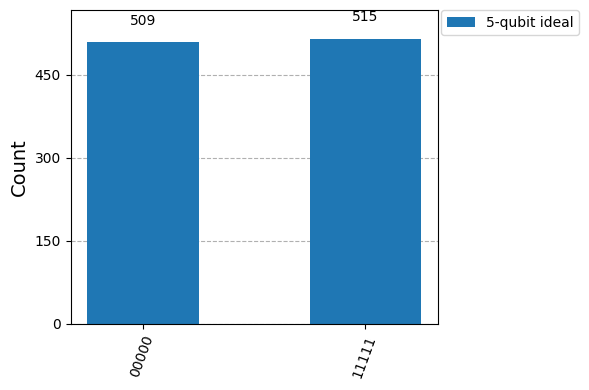

In [3]:
print("5-qubit GHZ counts (ideal):", counts5)
plot_histogram(counts5, legend=['5-qubit ideal'], figsize=(6, 4))

**Risultato atteso (caso ideale):** Lo stato GHZ a 3-qubit idealmente porta a esiti al 50% `000` e al 50% `111`. Lo stato GHZ a 5-qubit porta a ~50% `00000` e 50% `11111`. Nessun altro esito spunta, in quanto perfettamente coerente ed entangled (idealmente). L'istogramma apparirà con solo due barre, una per ciascuno stato possibile.

Successivamente, vedremo cosa succede in un **ambiente rumoroso**. useremo il modello di rumore Aer di Qiskit per simulare gli errori di un dispositivo reale. Ad esempio, possiamo prendere il backend di IBM per creare un modello rumoroso che include errori sui gate, tempo limitato per i gate, rilassamento dei qubit (T₁), sfasamento (T₂), ed errori di lettura. Useremo quindi un **finto backend** che rappresenta l'IBM Quantum Brisbane device per generare un modello di rumore, e ri-eseguiremo il circuito GHZ tramite esso.

### Esercizio 1a: Simulazione con rumore
Completa il codice sottostante per simulare il circuito GHZ in un simulatore rumoroso basato sul backend `FakeBrisbane`. Questo dimostrerà come le performance degenerino in un ambiente rumoroso, più vicino a quello reale.

3-qubit GHZ counts (noisy): {'000': 476, '001': 15, '111': 478, '101': 16, '010': 15, '110': 7, '100': 9, '011': 8}


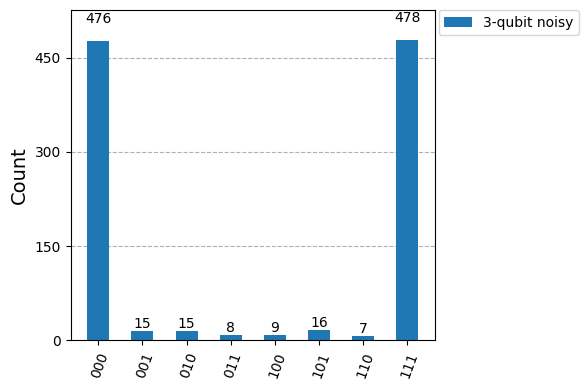

In [4]:
from qiskit_ibm_runtime.fake_provider import FakeBrisbane

# We will reuse the ideal circuits qc3 and qc5 and their results from the previous cell.

# --- YOUR CODE HERE ---

# 1. Create a fake backend for IBM Quantum Brisbane
brisbane_backend = FakeBrisbane()

# 2. Create a noisy AerSimulator from the fake backend's properties
noisy_sim = AerSimulator.from_backend(backend=brisbane_backend)

# 3. Transpile the circuits for the noisy simulator (this adapts them to the device's specific gates and connectivity)
pm = generate_preset_pass_manager(backend=noisy_sim)

isa_qc3_noisy = pm.run(qc3)
isa_qc5_noisy = pm.run(qc5)

# 4. Run the noisy simulations using the Sampler and get the counts
sampler = Sampler(mode=noisy_sim)

job3 = sampler.run([isa_qc3_noisy], shots=1024)
result3_noisy = job3.result()
counts3_noisy = result3_noisy[0].data.c.get_counts()

job5 = sampler.run([isa_qc5_noisy], shots=1024)
result5_noisy = job5.result()
counts5_noisy = result5_noisy[0].data.c.get_counts()


# --- END YOUR CODE ---

# This part is done for you to print and plot the results:
print("3-qubit GHZ counts (noisy):", counts3_noisy)
plot_histogram(counts3_noisy, legend=['3-qubit noisy'], figsize=(6, 4))

5-qubit GHZ counts (noisy): {'11111': 457, '00000': 454, '00001': 10, '11110': 10, '11101': 12, '01111': 14, '01000': 6, '00010': 9, '00100': 8, '10000': 12, '10010': 1, '11011': 13, '10101': 1, '00110': 3, '10111': 5, '10001': 2, '11001': 4, '01010': 1, '01001': 1, '01101': 1}


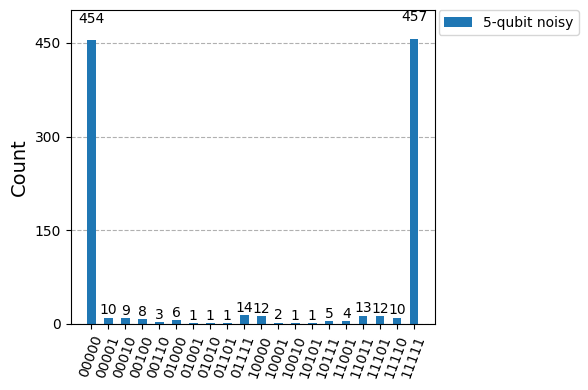

In [5]:
print("5-qubit GHZ counts (noisy):", counts5_noisy)
plot_histogram(counts5_noisy, legend=['5-qubit noisy'], figsize=(6,4))

### Esercizio 1b: Esegui su un vero computer quantistico di IBM
Il codice sottostante verrà eseguito su un vero computer quantistico di IBM. Questo dimostrerà il degenerare delle performance su hardware reale.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

crn = "your_crn_here"
your_token = "your_token_here"

QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=your_token,
    instance=crn,
    overwrite=True,
    set_as_default=True
)

service = QiskitRuntimeService()
service.backends()

# We will reuse the ideal circuits qc3 and qc5 and their results from the previous cell.

service = QiskitRuntimeService()
real_backend = service.least_busy(operational=True, simulator=False)
print("Running on " + real_backend.name)

pm = generate_preset_pass_manager(backend=real_backend, optimization_level=1)
isa_qc3r = pm.run(qc3)
isa_qc5r = pm.run(qc5)

sampler = Sampler(mode=real_backend)

job3r = sampler.run([isa_qc3r], shots=1024)
result3r = job3r.result()
counts3r = result3r[0].data.c.get_counts()

job5r = sampler.run([isa_qc5r], shots=1024)
result5r = job5r.result()
counts5r = result5r[0].data.c.get_counts()

print("3-qubit GHZ counts (real):", counts3r)
plot_histogram(counts3r, legend=['3-qubit real'], figsize=(6,4))

In [ ]:
print("5-qubit GHZ counts (real):", counts5r)
plot_histogram(counts5r, legend=['5-qubit real'], figsize=(6,4))

**Output atteso (rumoroso vs ideale):** Col rumore, che sia simulato o su un dispositivo reale, lo stato GHZ è **imperfetto**. Noterai infatti risultati diversi da tutti-0 e tutti-1. Su 3 qubit, invece del 100% di `000`/`111`, saranno visibili ulteriori stati (`001`, `010`, etc.) a causa di errori nei gate e decoerenza, che porterà a dei bit-flip. Su 5 qubit, l'effetto è ancora più pronunciato; più grande è il circuito (più qubit e porte CNOT) più si accumulano gli errori, con stati tutti-0 e tutti-1 meno presenti, e più stati non attesi. Questo trend mostra la sfida intrinseca alla *scalabilità*: scalando le dimensioni, mantenere alta fedeltà nei risultati diventa sempre più difficile, senza dei meccanismi di mitigazione degli errori.

**Intuizione:** Un computer quantistico scalabile necessita di preservare la correlazione quantistica nonostante la crescita del sistema. I nostri esempi dimostrano come il numero di qubit e la profondità del circuito siano inversamente proporzionale alla fedeltà del circuito, quando è presente del rumore.

## 2. Criterio 2 – Inizializzazione dei qubit

**Criterio 2:** *“Possibilità di inizializzare i qubit ad uno specifico stato (ad esempio |00…0〉).”* Tutti i qubit devono poter essere inizializzati in maniera affidabile ad uno stato di riferimento noto (tipicamente lo stato ground |0〉 per ogni qubit). L'inizializzazione è necessaria per far partire gli algoritmi su uno stato di partenza pulito algorithms. In practica, negli IBM quantum device ogni qubit è automaticamente resettato a |0〉 all'inizio di ogni esecuzione di un circuito. Qiskit fornisce anche istruzioni per resettare qubit e preparare stati personalizzati durante la computazione.

**Obiettivo della Demo:** Mostrare come inizializzare i qubit in Qiskit, sia all'inizio che a metà circuito. Dimostreremo l'uso dell'istruzione `reset` e i metodi di preparazione dello stato.

### Esercizio 2: Preparare uno stato specifico
Nel codice sottostante, completa il `QuantumCircuit` per preparare lo stato $|10\rangle$. Il qubit 0 dovrà essere allo stato $|0\rangle$ e il qubit 1 dovrebbe essere nello stato $|1\rangle$. Usa i gate e le istruzioni appropriate.

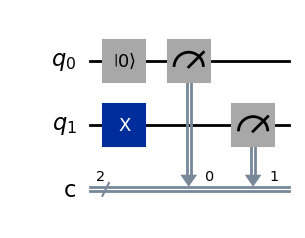

In [9]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

# Create a circuit to initialize qubits to |10> and verify by measurement
qc_init = QuantumCircuit(2, 2)

# --- YOUR CODE HERE ---

# 1. Set qubit 1 to the |1> state
qc_init.x(1)

# 2. Explicitly reset qubit 0 to the |0> state
qc_init.reset(0)

# --- END YOUR CODE ---

qc_init.measure([0, 1], [0, 1])
qc_init.draw('mpl')

Outcome of |10> state measured in Z-basis: {'10': 1024}


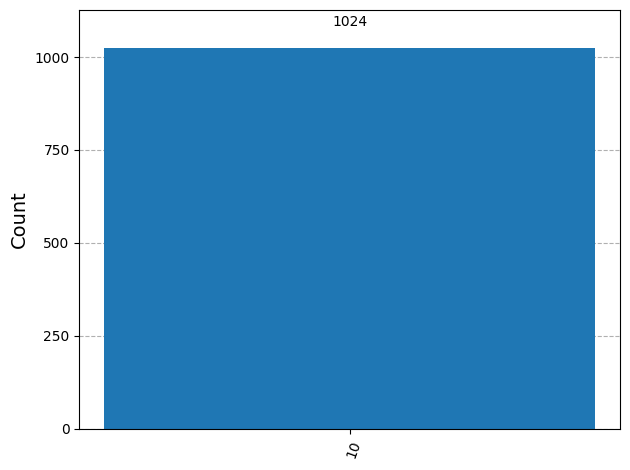

In [10]:
# Run the circuit and check the outcome
sim_backend = AerSimulator()
pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=1)
isa_qc_init = pm.run(qc_init)

sampler = Sampler(mode=sim_backend)
# try this too
# sampler = Sampler(mode=real_backend)

job = sampler.run([isa_qc_init], shots=1024)
result = job.result()
counts = result[0].data.c.get_counts()

print("Outcome of |10> state measured in Z-basis:", counts)
plot_histogram(counts)

Il risultato dovrebbe essere `10` (qubit1=1, qubit0=0) con probabilità 100%, e quindi il qubit 1 sarà stato messo a |1〉 e il qubit 0 a |0〉 in maniera corretta.

Ora, per una preparazione degli stati iniziali più generale, Qiskit offre un inizializzazione a stati arbitrari usando il metodo `initialize`. Ad esempio, prepariamo un qubit nello stato $|+\rangle = (|0\rangle+|1\rangle)/\sqrt{2}$, che è uno stato in superposizione, e un paio di qubit nello stato di Bell $(|00\rangle+|11\rangle)/\sqrt{2}$:

In [11]:
import numpy as np

# Initialize a single qubit in |+> state and measure in Z-basis
qc_plus = QuantumCircuit(1, 1)
state_plus = [1/np.sqrt(2), 1/np.sqrt(2)]   # amplitude for |0> and |1>
qc_plus.initialize(state_plus, 0)
qc_plus.measure(0, 0)

# Initialize two qubits in a Bell state manually
qc_bell = QuantumCircuit(2, 2)
# amplitudes for |00>,|01>,|10>,|11>
bell_state = [1/np.sqrt(2), 0, 0, 1/np.sqrt(2)]
qc_bell.initialize(bell_state, [0, 1])
qc_bell.measure([0, 1], [0, 1])

# Transpile and run the initialization circuits
isa_qc_plus = pm.run(qc_plus)
job_plus = sampler.run([isa_qc_plus], shots=1024)
result_plus = job_plus.result()
counts_plus = result_plus[0].data.c.get_counts()

print("Outcome of |+> state measured in Z-basis:", counts_plus)

isa_qc_bell = pm.run(qc_bell)
job_bell = sampler.run([isa_qc_bell], shots=1024)
result_bell = job_bell.result()
counts_bell = result_bell[0].data.c.get_counts()

print("Outcome of Bell state measured in Z-basis:", counts_bell)

Outcome of |+> state measured in Z-basis: {'1': 531, '0': 493}
Outcome of Bell state measured in Z-basis: {'00': 492, '11': 532}


**Risultato atteso:** Lo stato |+〉 del singolo qubit, quando misurato, collasserà a `0` o `1` con probabilità circa 50% per ciascuno dei possibili stati. La misurazione dello stato di Bell dovrebbe dare circa 50% `00` and 50% `11`. Se sono questi gli esiti, l'inizializzazione è avvenuta con successo.

**Inizializzazione a metà circuito:** Il metodo `reset` di Qiskit può essere utilizzato a metà circuito per reinizializzare un qubit a |0〉 al volo. Ad esempio, in codici di correzione degli errori o in algoritmi iterativi, un qubit viene spesso misurato e poi resettato per essere riutilizzato. L'operazione di `reset` è deterministica; cestina qualsiasi stato presente e porta il qubit allo stato di ground.

**Esempio su dispositivo:** Su hardware come l **ibmq_brisbane** (127 qubits) o qualsiasi dispositivo quantum di IBM, tutti i qubit partono da |0〉 di default ogni qual volta si esegua un job. Se sono necessari altri stati di partenza, si applicano gli opportuni gate (come quando abbiamo applicato il gate X per ottenere |1〉). Le reinizializzazioni continue (per la correzione degli errori) sono un argomento di ricerca molto importante, in quanto effettuarle velocemente è una grossa sfida. Fortunatamente, per usi basilari, partire dallo stato |0…0〉 è un'opzione più che valida, e abbiamo già tutti gli strumenti per passare ad altri stati.

## 3. Criterio 3 – Lunghi tempi di coerenza (Decoerenza vs Tempo di esecuzione dei gate)

**Criterio 3:** *“Tempi di decoerenza abbastanza lunghi, più lunghi del tempo di esecuzione delle porte.”* Questo fa riferimento alla necessità, da parte dei qubit, di mantenere abbastanza a lungo lo stato quantistico, in modo da poter effettuare tutte le operazioni necessarie. Ogni qubit ha **tempo T₁** (tempo di rilassamento energetico, quanto velocemente |1〉 decade a |0〉) e **tempo T₂** (tempo di sfasamento, quanto velocemente si perde la coerenza di fase). Per il funzionamento di un computer quantistico, questi lassi di tempo dovrebbero durare molto più del tempo di esecuzione delle porte.

**Obiettivo della Demo:** Investigare sulla coerenza dei qubit in Qiskit mostrando come la decoerenza impatti i risultati, soprattutto su lunghi tempi di esecuzioni. Useremo un falso backend con tempi T1/T2 noti per simulare questo effetto.

Per **dimostrare l'impatto del tempo di coerenza finito**, simuleremo un esperimento di decadenza di T1. Prepareremo un qubit nello stato |1〉, aspetteremo un po' di tempo con l'istruzione `delay`, e poi misureremo. Ci aspettiamo che la probabilità di misurare |1〉 decadi ad ogni aumento di delay.

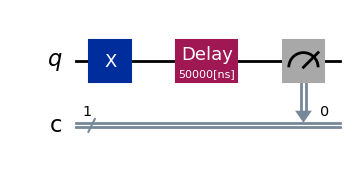

In [12]:
# This part is done for you. We are creating a list of circuits,
# each with a different delay time.

time_delays_ns = [0, 50000, 100000, 150000, 200000, 250000, 300000]  # delay durations in ns

decay_expts = []
for delay in time_delays_ns:
    qc = QuantumCircuit(1, 1)
    qc.x(0)  # initialize qubit to |1>
    if delay > 0:
        qc.delay(delay, 0, unit='ns')  # wait 'delay' nanoseconds
    qc.measure(0, 0)
    decay_expts.append(qc)

decay_expts[1].draw('mpl')  # Visualize one of the circuits

### Esercizio 3: Simulare un esperimento sulla decadenza di T1

Adesso, usiamo un simulatore rumoroso basato su `FakeVigo` (che ha tempo T1 di circa ~50-100 µs, *microsecondi*) per eseguire questi circuiti. Il simulatore applicherà automaticamente gli errori relativi a T1/T2 durante le istruzioni `delay`. Transpila il circuito per questo backend ed eseguilo.

In [13]:
from qiskit_ibm_runtime.fake_provider import FakeVigoV2 as FakeVigo
from qiskit_aer import AerSimulator

# --- YOUR CODE HERE ---

# 1. Create a noisy simulator from the FakeVigo backend
sim_vigo = FakeVigo()

# 2. Transpile the list of circuits for this simulator
pm = generate_preset_pass_manager(backend=sim_vigo)

isa_decay_expts = pm.run(decay_expts)

# 3. Use the Sampler to run all the transpiled circuits in a single job
sampler = Sampler(mode=sim_vigo)
job = sampler.run(isa_decay_expts)
result = job.result()

# --- END YOUR CODE ---

# This part is done for you to analyze and print the results.
for idx, (delay, qc) in enumerate(zip(time_delays_ns, isa_decay_expts)):
    counts = result[idx].data.c.get_counts()
    p1 = counts.get('1', 0) / 1000  # Assuming 1000 shots
    print(f"Delay {delay} ns: P(qubit=1) = {p1:.3f}")

Delay 0 ns: P(qubit=1) = 0.996
Delay 50000 ns: P(qubit=1) = 0.613
Delay 100000 ns: P(qubit=1) = 0.385
Delay 150000 ns: P(qubit=1) = 0.229
Delay 200000 ns: P(qubit=1) = 0.120
Delay 250000 ns: P(qubit=1) = 0.092
Delay 300000 ns: P(qubit=1) = 0.056


Dovresti osservare la probabilità `P(qubit=1)` decadere quando il delay aumenta, seguendo una curva di decadenza esponenziale caratteristica del rilassamento di T1. Questo dimostra direttamente come il tempo di coerenza finito porti a errori computazionali se il circuito viene eseguito per troppo tempo.

**Impatto sugli algoritmi:** Se provi algoritmi più lunghi (con molte porte in sequenza), l'esecuzione totale si avvicina e può superare T2, causando perdita di coerenza prima della fine dell'esecuzione. Ecco perché migliorare il tempo di coerenza e rendere le porte più veloci, è un punto critico nella ricerca nell'ambito hardware quantistico.

## 4. Criterio 4 – Set universale di porte quantistiche

**Criterion 4:** *“A ‘universal’ set of quantum gates.”* Il nostro hardware deve permetterci di eseguire *qualsiasi* computazione quantistica componendo un set finito di porte base. Nella computazione classica, sappiamo già che la porta NAND è universale; nel quantum computing, ci sono molti set universali di porte ({H, T, CNOT} o le porte native di ogni macchina). I dispositivi di IBM, per esempio, hanno un set di operazioni native, come operazioni di rotazione arbitrarie a singolo qubit e CNOT tra certi qubit, che assieme compongono un insieme universale. Il lavoro di Qiskit è spesso quello di **compilare gate di alto livello in gate base universali**.

**Obiettivo della Demo:** Illustrare universalità dei gate mostrando come Qiskit li decomponga. Prenderemo dei gate non-nativi (come il gate di Toffoli a 3-qubit 3, CCX) e vedremo come sono composti nei gate di base del dispositivo. Questo dimostra che il set di gate fornito è, senza ombra di dubbio, *universale* – permettendo quindi di effettuare operazioni molto complesse.

Prima, vediamo cosa sono i gate di base in un tipico backend di IBM. Otterremo la configurazione di qualsiasi dispotivo reale (or la sua versione fake), usando `.configuration().basis_gates`. Ad esempio, i gate di base del backend ibmq_brisbane sono:

In [14]:
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
fake_brisbane = FakeBrisbane()
print("Basis gates for ibmq_brisbane:", fake_brisbane.configuration().basis_gates)

Basis gates for ibmq_brisbane: ['ecr', 'id', 'rz', 'sx', 'x']


Questo darà un output del tipo `['id', 'rz', 'sx', 'x', 'ecr']`. Queste sono le operazioni primitive che nell'hardware supporta nativamente (Identità/no-op, rotazione RZ, porta sqrt(X), porta X e X controllato). Qualsiasi altro gate sarà composto dall'unione di questi. Questo set è noto di essere universale per il quantum computing (un set universale è composto essenzialmente da rotazioni a singolo qubit + un gate di entanglement a due qubit).

Ora, prendiamo un **gate di Toffoli (CCX)** come test-case. CCX ruota un qubit solo se due qubit di controllo sono entrambi a 1. Non è un gate nativo nell'hardware di IBM. Qiskit fornisce un'istruzione `ccx`, ma dietro le quinte verrà decomposta.

### Esercizio 4: Decomponiamo un gate di Toffoli
Completa il codice sottostante per costruire un circuito con un gate di Toffoli (CCX), poi usa Qiskit per decomporlo nei gate base nativi del backend `FakeBrisbane`.

In [15]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeBrisbane

# The fake_brisbane backend from the previous cell is reused here.

# --- YOUR CODE HERE ---

# 1. Create a circuit that can accommodate a Toffoli gate
qc_toffoli = QuantumCircuit(3)

# Apply a CCX gate with controls on qubits 0, 1 and target on qubit 2
qc_toffoli.ccx(0, 1, 2)

# 2. Transpile the circuit to the fake Brisbane backend
pm = generate_preset_pass_manager(backend=fake_brisbane)

isa_qc_toffoli = pm.run(qc_toffoli)


# --- END YOUR CODE ---

print("Toffoli circuit before decomposition:")
print(qc_toffoli)

print("\nToffoli circuit after transpiling to Brisbane basis:")
# The .draw() method will now show the decomposed circuit
print(isa_qc_toffoli.draw(fold=120))

Toffoli circuit before decomposition:
          
q_0: ──■──
       │  
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘

Toffoli circuit after transpiling to Brisbane basis:
global phase: 5π/8
              ┌────┐   ┌──────────┐                                           ┌──────┐   ┌────┐                    »
q_0 -> 123 ───┤ √X ├───┤ Rz(-π/2) ├───────────────────────────────────────────┤1     ├───┤ √X ├────────────────────»
              ├────┤   ├─────────┬┘┌──────┐┌───────────┐   ┌────┐   ┌────────┐│  Ecr │┌──┴────┴──┐┌────┐┌─────────┐»
q_2 -> 124 ───┤ √X ├───┤ Rz(π/2) ├─┤1     ├┤ Rz(-3π/4) ├───┤ √X ├───┤ Rz(-π) ├┤0     ├┤ Rz(-π/2) ├┤ √X ├┤ Rz(π/4) ├»
           ┌──┴────┴──┐└─────────┘ │  Ecr │└───┬───┬───┘┌──┴────┴──┐└────────┘└──────┘└──────────┘└────┘└─────────┘»
q_1 -> 125 ┤ Rz(-π/2) ├────────────┤0     ├────┤ X ├────┤ Rz(-π/2) ├───────────────────────────────────────────────»
           └──────────┘            └──────┘    └───┘    └──────────┘                                          

Nell'output transpilato, dovresti vedere il gate CCX rimpiazzato da una sequenza di gate basilari, come i gate `rz`, `sx` e `ecr`. Questo dimostra che i gate nativi sono sufficienti a replicare il gate di Toffoli.

**Universalità nel pratico:** L'esercizio appena svolto dimostra che un gate complesso come questo gate a 3-qubit sia in realtà costituito da più gate nativi. In generale, **qualsiasi** gate a più qubit può essere composto da gate a 1- e 2-qubit. Il transpilatore è quindi un componente fondamentale in ogni quantum software stack, in quanto fa da ponte tra gli algoritmi astratti che vogliamo eseguire, e le operazioni fisiche tipiche dello specifico dispositivo.

**Esempio di dispositivo:** L'**ibmq_brisbane** usa l'architettura Eagle con la lista di gate precedentemente citata. Questo significa che ogni algoritmo ad esso mandato, sarà in realtà tradotto in una sequenza di queste istruzioni. Questo criterio fa quindi riferimento alla **controllabilità**; è necessario avere abbastanza operazioni base per effettuare qualsiasi tipo di operazione complessa sui qubit.

## 5. Criterion 5 – Misurabilità dei qubit

**Criterio 5:** *“Possibilità di misurare specifici qubit”* Lo stato di ogni qubit deve essere misurabile (typicamente nella base computazionale, |0〉 or |1〉). In altre parole, dopo aver eseguito un circuito quantistico, dobbiamo poter leggere tutti i qubit come bit 0/1 classici. Questo criterio fa riferimento all'avere un modo affidabile per leggere il valore dei qubit, in modo da poter anche specificare quale qubit misurare.

**Obiettivo della Demo:** Mostrare come effettuare misurazioni a qubit specifici in Qiskit su simulatori e dispositivi reali, ed evidenziarne le differenze (come il rumore di misurazione). Misureremo alcuni qubit in vari stati ed esamineremo i risultati. Dimostreremo come gli errori di lettura possono apparire confrontando i risultati dei simulatori con quelli dell'hardware reale.

Per prima cosa, diamo un esempio di misurazione:

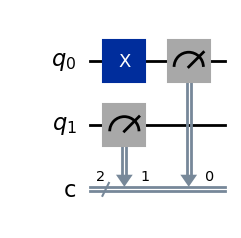

In [16]:
qc_measure = QuantumCircuit(2, 2)
qc_measure.x(0)              # qubit 0 -> |1>, qubit 1 stays |0>
qc_measure.measure([0, 1], [0, 1])
qc_measure.draw('mpl')

In [17]:
sim_backend = AerSimulator()
pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=1)
isa_qc_measure = pm.run(qc_measure)
sampler = Sampler(mode=sim_backend)
job = sampler.run([isa_qc_measure], shots=1000)
result = job.result()
counts = result[0].data.c.get_counts()

print("Simulator measurement counts:", counts)

Simulator measurement counts: {'01': 1000}


Ci aspettiamo 1000 misurazioni di `01` nel simulatore. Ora, vediamo gli **errori di misurazione** in azione, simulandoli. Possiamo aggiungere degli errori di lettura al nostro Aer simulator. Qiskit Aer ci permette di definire un `ReadoutError` e di aggiungerlo ai qubit tramite un noise model.

### Esercizio 5: Simulare errori di lettura
Completa il codice per definire un semplice modello con errori di lettura dove ogni qubit ha una chance 2% di essere misurato in maniera errata (0 letto come 1, 1 letto come 0). Poi, esegui le misurazioni con un modello di rumore.

In [24]:
from qiskit_aer.noise import NoiseModel, ReadoutError

# --- YOUR CODE HERE ---

# 1. Define a 2% readout error for each single qubit.
# The format is a list of lists of probabilities: [[P(0|0), P(1|0)], [P(0|1), P(1|1)]]
# P(A|B) is the probability of measuring A given the state was |B>.
ro_error = ReadoutError([[0.98, 0.02], [0.02, 0.98]])

# 2. Create a new noise model
noise_model_ro = NoiseModel()

# 3. Add the readout error to all qubits in the noise model
noise_model_ro.add_all_qubit_readout_error(ro_error)

# --- END YOUR CODE ---

sim_backend = AerSimulator()
sim_backend.set_options(noise_model=noise_model_ro)
pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=1)
isa_qc_measure = pm.run(qc_measure)

# Run the measurement circuit with readout noise
sampler = Sampler(mode=sim_backend)

job = sampler.run([isa_qc_measure], shots=1024)
result = job.result()
counts = result[0].data.c.get_counts()

print("Simulation with 2% readout error:", counts)

Simulation with 2% readout error: {'01': 968, '11': 33, '00': 23}


Questo output simulato mostrerà degli errori di simulazione (`11`, `00`, `10`) simili a ciò che l'hardware reale potrebbe produrre, dimostrando l'impatto delle misurazioni imperfette.

**Esempio su dispositivo:** Su un dispositivo reale, come l'**ibmq_brisbane**, puoi eseguire lo stesso circuito e misurare simili valori non-zero, chiaramente sbagliati. I dati relativi alla calibrazione del dispositivo indicano errori di lettura su qualsiasi qubit. Riuscire a isolare e misurare singoli qubit, e capire come si presentano gli errori, è fondamentale per ottenere dati significativi. L'esecuzione su hardware reale è stata dimostra nell'**Esercizio 1b**.

## Criteri di comunicazione quantistica (qubit volanti)

DiVincenzo ha inoltre definito due criteri fondamentali relativi alla quantum communication, importanti da considerare nella costruzione di quantum computer interconnessi:

6. **Capacità di interconvertire qubits stazionari e volanti.** (mappare un qubit in un processore ad un fotone che può viaggiare.)
7. **Capacità di trasmettere fedelmente qubits volanti tra posti diversi.** (mandare un fotone qubit attraverso la fibra senza perdere informazione quantistica.)

Questi vanno oltre gli utilizzi standard di Qiskit, in quanto questo viene principalmente usato per lavorare con qubit stazionari su dei chip. Possiamo tuttavia illustrare il concetto dietro questi criteri attraverso un esempio: **il teletrasporto quantistico**. Il teletrasporto mostra la conversione dello stato di un qubit stazionario, trasportata da un qubit volante, grazie al loro entanglement. Questo permette di ricostruire un qubit stazionario da un'altra parte.

### Attività consigliata: *Quantum Teleportation*

Il modulo *Qiskit in Classrooms* sul [Quantum Teleportation](https://quantum.cloud.ibm.com/learning/en/modules/computer-science/quantum-teleportation) dal Dr. Katie McCormick vi guiderà in uno dei protocolli più accattivanti di quantum information: il teletrasporto quantistico, dove uno stato quantistico (un qubit) è mandato da Alice a Bob usando l'entanglement e solo due bit classici. Imparerete l'intera procedura di teletrasporto step-by-step— come creare la coppia nello stato di Bell in entanglement, effettuare un misuramento nella base di Bell-basis dal lato di Alice, trasmettere risultato classico, e applicare le porte quantistiche opportune sul qubit dal lato di Bob, in modo da ottenere lo stato originale. Nel processo, scoprirete anche perché il teletrasporto delle informazioni relative a un qubit non viola il teorema di non clonazione, e non supera la velocità della luce. Tramite esercizi svolti su hardware quantistico di IBM o simulatori, avrete modo di vedere in azione le misurazioni, l'entanglement, e il feed-forward control.

Capendo bene il teletrasporto quantistico, capirete come codificare, trasmettere, e recuperare informazione quantistica tra nodi distinti, mettendo così, le basi per le reti quantistiche, sistemi di repeater, schemi di comunicazione sicura, e computazione quantistica scalabile e modulare.

**Come ciò si relaziona ai criteri 6 e 7:** In una vera rete quantistica, la coppia condivisa in entanglement è creata distribuendo qubit "volanti" (come i fotoni) tra Alice e Bob (Criterio 7: trasmissione affidabile). Il protocollo di teletrasporto in se, offre un modo per mappare il qubit stazionario di Alice in ad una metà di una coppia in entanglement, nell'effettivo "mandandolo" a Bob (Criterio 6: interconversione). Qiskit ci permette di simulare la logica del protocollo perfettamente, fornendo dei modelli concettuali per come questi criteri sono soddisfatti nelle architetture di comunicazione.

## Conclusioni e sommario

Abbiamo definito una serie di esercizi di programmazione in Qiskit per illustrare i criteri di DiVincenzo. Tramite questi esempio, abbiamo esplorato come una vera piattaforma di quantum computing soddisfa ciascun requisito:

- **Scalabilità**: costruire circuiti su più qubit e capire la crescita del rumore.
- **Inizializzazione**: usare reset e preparazione degli stati per avviare la computazione in maniera affidabile a stati noti.
- **Gate Universali**: transpilare operazioni complesse in gate di base dell'hardware, dimostrando di poter svolgere qualsiasi computazione.
- **Misurazione**: leggere il valore dei qubit e gestire errori di lettura realistici.
- **Coerenza**: vedere l'effetto della durata finita di T₁, T₂ sulla fedeltà dei risultati degli algoritmi e il bisogno di avere tempi di operazione molto veloci rispetto al tempo di decoerenza.

Per completezza, abbiamo toccato alcuni aspetti di comunicazione quantistica in Qiskit nel corso in [Quantum Teleportation](https://quantum.cloud.ibm.com/learning/en/modules/computer-science/quantum-teleportation), associandoli anche ai due criteri associati (qubit volanti).


È importante sapere come questi criteri entrino in gioco in veri computer quantistici come quelli di IBM. In dispositivo come **ibmq_brisbane** ha 127 qubit superconduttori (Criterio 1), che partono sempre dallo stato |0〉 (Criterio 2), con un set di porte calibrate e compiatori per ottenere universalità (Criterio 4), risonatori a microonde per leggere ciascun qubit (Criterio 5), e tempi di coerenza dell'ordine delle centinaia di microsecondi contro le operazioni, che richiedono nano secondi (Criterio 3). Per esperimenti nelle reti quantistiche , IBM e altri stanno esplorando la trasduzione microonde-a-ottico per i qubit volanti, e l'entanglement tra qubit distanti (Criteri 6 e 7); queste sono aree di ricerca molto attive.

Completando gli esercizi di questo notebook, non solo avete visto le definizioni relative ai criteri di DiVincenzo, ma le avete *toccate con mano* attraverso il codice; costruendo anche intuizioni relative alle implicazioni sull'hardware reale e sugli algoritmi, di ciascun requisito. Estendete liberamente questi esperimenti, e felice quantum computing!